In [1]:
import os


import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import skimage.io as io
from skimage.io import imread_collection

import utils

%matplotlib inline

#To reload imported modules without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
# Takes input directory where you have sub and no-_sub directories and creates train and test split
input_dir = "/home/devendra/projects/gsoc/lenses/"
train,test = utils.prepare_data(input_dir, train_ratio=0.7)

Reading from Existing CSV File:  /home/devendra/projects/gsoc/lenses/lense.csv
***Now creating Train-Test Split***
Found Existing train.csv at : /home/devendra/projects/gsoc/lenses/train/train.csv
Found Existing test.csv at : /home/devendra/projects/gsoc/lenses/test/test.csv


In [3]:
# path to test and train directories
train_dir = os.path.join(input_dir, 'train')
train_dir = '/home/devendra/projects/gsoc/lenses/train/'
test_dir = os.path.join(input_dir, 'test')

# transforms to be applied on each image while loading
transform = transforms.Compose([transforms.Resize((112, 112)),
                                transforms.ToTensor()])

# Loading images
train_data = datasets.ImageFolder(train_dir, transform = transform)
test_data = datasets.ImageFolder(test_dir, transform = transform)

#Defining dataloaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)

In [4]:
class Autoencoder(nn.Module):
   
    def __init__(self):

        super(Autoencoder, self).__init__()

        # Encoder
        ## Conv2D -> ReLu -> Conv2D -> ReLU->Conv2D
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 7,
                      stride = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 7,
                      stride = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 7)
        )

        # Decoder 
        ## ConvTrans2D -> ReLu -> ConvTrans2D -> ReLU->ConvTrans2D -> Sigmoid
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 7),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = 7,
                               stride = 3, padding = 1, output_padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 16, out_channels = 3, kernel_size = 7,
                               stride = 3, padding = 1, output_padding = 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        '''Forward pass through the network'''
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

In [5]:
def train(model, optimizer, loss_func, train_loader, num_epochs=5):
    '''
        Function to train model on training dataset

        params:
            model: model architecture for training
            optimizer: OptimizerClass() object 
            loss_func: Loss function from LossClass()
            train_loader: DataLoader object
            num_epochs: number of epochs to train model 
            
        return: 
            results: list of tuples of the form (epoch, input_images, output_images)
    '''
    # set device to GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    print("***** Training Begins *****")
    
    results = []
    for epoch in range(num_epochs):
        for images, _ in train_loader:
            images = images.to(device)

            outputs = model(images)
            loss = loss_func(outputs, images)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # print training logs
        print('Epoch:{} | Training loss:{:.4f}'.format(epoch+1, float(loss)))
        #cache results
        results.append((epoch, images, outputs),)
    return results


def infer(model, device, test_loader):
    '''
        Function to test trained model on testing dataset

        params: 
            model: model to be used for inference
            test_loader: DataLoader object for testing data
        
        returns: 
            losses: list of loss on each image
    '''

    model.eval()
    losses = []

    for images,_ in test_loader:
       images = images.to(device)
       output = model(images)
       loss = nn.MSELoss()(output, images)
       losses.append(loss.item())
    return losses

In [10]:
def save_model(model, optimizer, path):
    '''
     Method to save trained model
     -------------------------------------
     params: 
         model: model to save
         optimizer: corresponding optimizer associated with model
         path: path to store model
    '''

    torch.save({
        'model': model.state_dict(), 
        'optimizer' : optimizer.state_dict(),
        }, path)
    
    
def load_model(path):
    '''
      Method to load saved model
      
      params: 
          save_path: path to location where model was saved

      returns: 
          dict: {'model' : model, 'optimizer' : optimizer}
    '''

    return torch.load(path)


def visualize_training(results, num_epochs, print_every=5):
    '''
        Method to display results after training
        
        params: 
            results: from train()
            num_epochs: effective number of epochs to visualize
            print_every: number of epochs to skip between each displayed result
            
        returns:
        
    '''

    for epoch in range(0, num_epochs, print_every):
        fig = plt.figure(figsize=(15, 3))
        fig.suptitle(f"Epoch: {epoch}")

        input_img = results[epoch][1].detach().cpu().numpy()
        output_img = results[epoch][2].detach().cpu().numpy()

        # display input images
        for i, item in enumerate(input_img):
            if i<=5:
                plt.subplot(2, 5, i+1)
                plt.imshow(item[0], cmap='gray', aspect='auto')
        # display corresponding output images
        for i, item in enumerate(output_img):
            if i<5:
                plt.subplot(2, 5, 5+i+1)
                plt.imshow(item[0], cmap='gray', aspect='auto')


def visualize_test_results(losses):
    '''
        Method to display test results

        params: 
        losses: list of losses from test()
        
        returns:
        
    '''

    sns.kdeplot(losses, shade = True).set_title("Loss Distribution")
    # add rug plot
#     sns.rugplot(losses)
    plt.show()

In [33]:
import datetime
print(datetime.datetime.now())
model_save_path = "./gravitational_lensing_autoencoder_model_"+str(datetime.datetime.now()).replace(" ","_")+".pkl"
print(model_save_path)

2020-03-30 16:43:38.663260
./gravitational_lensing_autoencoder_model_2020-03-30_16:43:38.663454.pkl


***** Training Begins *****
Epoch:1 | Training loss:0.0084
Epoch:2 | Training loss:0.0092
Epoch:3 | Training loss:0.0086


/home/devendra/myinstallations/anaconda3/envs/i2dl/lib/python3.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


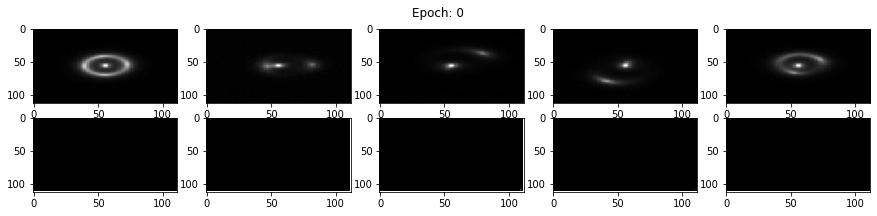

In [11]:
# Defining hyper-parameters for new model
num_epochs = 3
learning_rate = 1e-3


model = Autoencoder()
# move model to GPU if available
if torch.cuda.is_available():
    model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)

# Train model
results = train(model, optimizer, nn.MSELoss(), train_loader, num_epochs = num_epochs)

# Display training results
visualize_training(results, num_epochs, 5)

# change save path to where you want to save model

model_save_path = "./lensing_autoencoder_model_"+
                    str(datetime.datetime.now()).replace(" ","_")+".pkl"
save_model(model, optimizer, model_save_path)


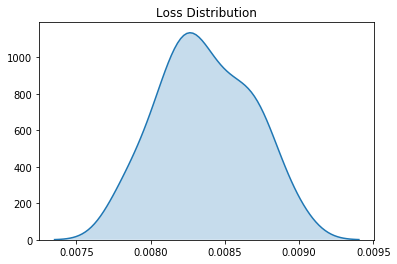

Test Loss: 0.0084


In [13]:
import seaborn as sns
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# test trained model
losses = infer(model, device, test_loader)

# display test results
visualize_test_results(losses)

# calculate and print average loss
avg_loss = sum(losses)/len(losses)
print("Test Loss: {:.4f}".format(avg_loss))

### Things to be tried:
In no order of preference
- Early Stopping : If the model loss doesn't decrease for 2-3 consecutive epochs. stop training pre-emptively
- Enhance model capacity byt increasing layers
- Data Pre-processing : Use techniques like gaussian blur, Normalizing images, rotation, flipping etc.
- Automate Hyper-parameter search
- Use Sacred+omniboard to record results for future use
- Attach TensorBoard